In [1]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange
import cv2

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

# Import IMC data 

In [4]:
from skimage.transform import rotate

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (5, 90))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
        
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    img = contrast_stretching(img)
    img = img_as_ubyte(img)
    return img


In [5]:
experiment = "tonsil"
core = "DonorA"
datasets = [
    core + "_1",
    core + "_2",
    core + "_3",
    core + "_4",
    core + "_5",
    core + "_6",
]
datasets = [
    core + "_4",
]


imgs, markers = get_imgs(f"{experiment} {core}", "IMC")

In [6]:
# experiment = "Lung"
# core = "F7"
# datasets = [
#     # core + "_1",
#     # core + "_2",
#     core + "_3",
#     core + "_4",
# ]

# imgs, markers = get_imgs(f"{experiment} {core}", "IMC")

In [7]:
# import napari

# napari.view_image(np.stack(imgs), name=markers, channel_axis=0, visible=False)

In [9]:
subset_lung = ["HistoneH3"]
# subset_tonsil = ["DNA1", "DNA2", 'Ki67', 'CD21', 'COL1', 'CD38', 'Vimentin', 'CD20', 'H3K27me3', 'PD1']
subset_tonsil = ["DNA1", "DNA2", 'H3K27me3', 'Ki67', 'PD1']

img_dapi = np.max(contrast_stretching(imgs[[markers.index(marker) for marker in subset_tonsil]]), axis=0)
img_dapi = contrast_stretching(img_dapi)

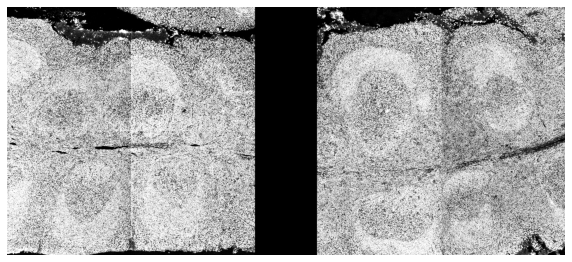

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_dapi, cmap="gray")
ax.axis("off")
plt.show()

In [11]:
imgs_dapi = []

for dataset in datasets:
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    img = crop_img(img_dapi, info)
    imgs_dapi.append(img)

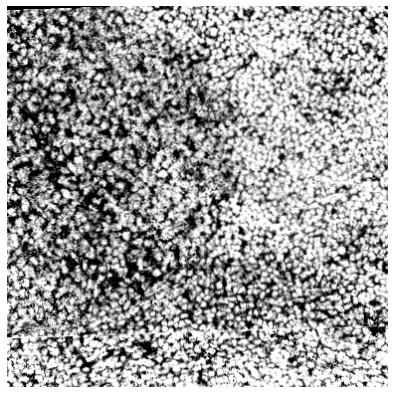

In [12]:
for img in imgs_dapi:
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    plt.show()

# Import SIMS data

In [13]:
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors


def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def get_imgs_index(imgs, index_list, fov_dim):

    imgs_subset = imgs[index_list, :, :]
    img_combined = np.sum(imgs_subset, axis=0)
    img_downscale = resize(img_combined, (fov_dim, fov_dim), anti_aliasing=False)
    return img_downscale

In [14]:
# imgs_sims = []

# for i, dataset in enumerate(datasets):
#     try:
#         info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
#     except:
#         continue
#     imgs, labels = get_imgs_sims(experiment, dataset)
#     # Read nulcie channel
#     img_nuclei_downscale = get_imgs_index(
#         imgs, [18, 32], fov_dim=imgs_dapi[i].shape[0]
#     )
#     # Contrast streching
#     p2, p98 = np.percentile(img_nuclei_downscale, (20, 99))
#     img_nuclei_downscale = exposure.rescale_intensity(
#         img_nuclei_downscale, in_range=(p2, p98), out_range=(0, 100)
#     )    
#     img_nuclei_downscale = img_nuclei_downscale.astype(np.uint8)

#     imgs_sims.append(img_nuclei_downscale)

In [15]:
# for img in imgs_sims:
#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.imshow(img, cmap="gray")
#     ax.axis("off")
#     plt.show()

In [16]:
# import napari 

# viewer = napari.view_image(np.stack([imgs_dapi[0], imgs_sims[0]]), channel_axis=0)

# Segmentation

In [17]:
import skimage.io
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import mark_boundaries


def save_mask(mask, folder, region):
    path = os.path.join(folder, f"{region}" + ".tif")
    skimage.io.imsave(path, mask)


def expand_labels(label_image, distance=1):
    distances, nearest_label_coords = distance_transform_edt(
        label_image == 0, return_indices=True
    )
    labels_out = np.zeros_like(label_image)
    dilate_mask = distances <= distance
    # build the coordinates to find nearest labels,
    # in contrast to [1] this implementation supports label arrays
    # of any dimension
    masked_nearest_label_coords = [
        dimension_indices[dilate_mask] for dimension_indices in nearest_label_coords
    ]
    nearest_labels = label_image[tuple(masked_nearest_label_coords)]
    labels_out[dilate_mask] = nearest_labels
    return labels_out

In [18]:
from cellpose import models, utils

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type="nuclei")


# Cyto segmentation
channels = [0, 0]
masks, flows, styles, diams = model.eval(
    imgs_dapi,
    diameter=5,
    flow_threshold=12.0,
    cellprob_threshold=-8.0,
    channels=channels,
    resample=True,
)

2022-08-05 16:35:06,143 [INFO] WRITING LOG OUTPUT TO C:\Users\thu71\.cellpose\run.log
2022-08-05 16:35:06,188 [INFO] >>>> using CPU
2022-08-05 16:35:06,232 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
2022-08-05 16:35:06,233 [INFO] ~~~ FINDING MASKS ~~~
2022-08-05 16:35:57,668 [INFO] >>>> TOTAL TIME 51.44 sec


In [19]:
masks_expanded = []
for mask in masks:
    masks_expanded.append(expand_labels(mask, distance=2))

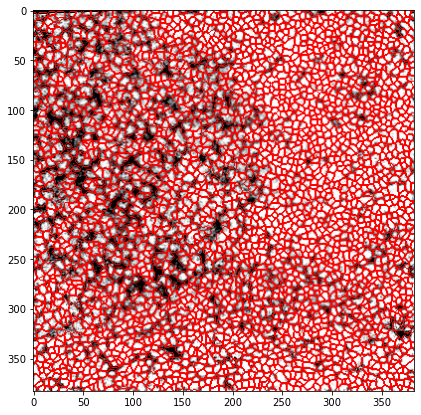

In [20]:
for i, mask in enumerate(masks):
    img_dapi = imgs_dapi[i]

    img_bnd = mark_boundaries(img_dapi, mask, color=(1, 0, 0))

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_bnd, cmap="gray")

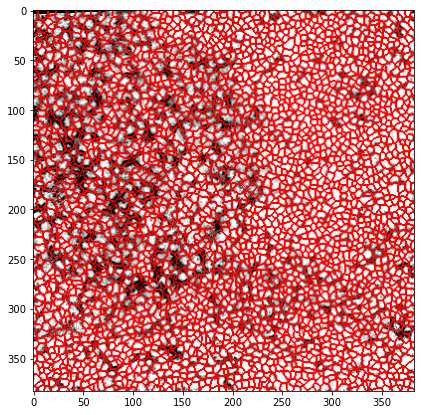

In [21]:
for i, mask in enumerate(masks_expanded):
    img_dapi = imgs_dapi[i]

    img_bnd = mark_boundaries(img_dapi, mask, color=(1, 0, 0))

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img_bnd, cmap="gray")

In [22]:
for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    save_mask(masks_expanded[i], data_dir / "masks", f"{experiment}_{dataset}")

C:\Users\thu71\AppData\Local\Temp/ipykernel_23252/1840332102.py:8: UserWarning: Y:\coskun-lab\Thomas\ScSpaMet\data\masks\tonsil_DonorA_4.tif is a low contrast image
  skimage.io.imsave(path, mask)
